## LangChain: Memory

When you interact with these models, they don't remember what you say before or any of the previous conversation, which is an issue when you are building some applications like chatbot and you want to have conversation with them. In this section we'll cover memory, which is basically how do you remember previous parts of the conversation and feed that into the language model so that they can have this conversational flow as you're interacting with them.

LangChain offers multiple sophisticated options of managing these memories. Let's jump in and take a look.

### Outline
- `ConversationBufferMemory`
- `ConversationBufferWindowMemory`
- `ConversationTokenBuffermemory`
- `ConversationSummaryMemory`

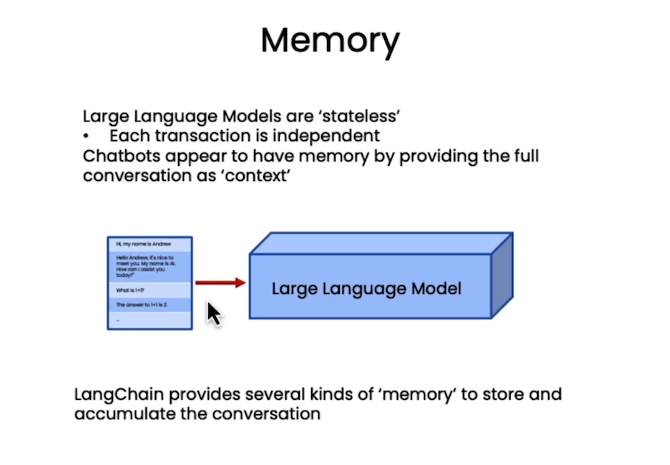

In [1]:
import openai
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

OPENAI_KEY = os.getenv('OPENAI_KEY')
openai.api_key = OPENAI_KEY

def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

#### ConversationBufferMemory
The ConversationBufferMemory is the most straightforward conversational memory in LangChain. As we described above, the raw input of the past conversation between the human and AI is passed — in its raw form — to the {history} parameter.

NOTE: you can use something like the code shown below to keep track of tokens used
```python
from langchain.callbacks import get_openai_callback

def count_tokens(chain, query):
    with get_openai_callback() as cb:
        result = chain.run(query)
        print(f'Spent a total of {cb.total_tokens} tokens')

    return result

count_tokens(
    conversation_buf, 
    "My interest here is to explore the potential of integrating Large Language Models with external knowledge"
)

## OUTPUT
Spent a total of 179 tokens

' Interesting! Large Language Models are a type of artificial intelligence that can process natural language and generate text. They can be used to generate text from a given context, or to answer questions about a given context. Integrating them with external knowledge can help them to better understand the context and generate more accurate results. Is there anything else I can help you with?'
```

In [12]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

chat = ChatOpenAI(temperature=0.0, model="gpt-3.5-turbo", openai_api_key=OPENAI_KEY)

memory = ConversationBufferMemory()
conversation = ConversationChain(
    llm=chat, memory=memory, verbose=True # verbose: True will show what the langchain is doing
)

In [13]:
conversation.predict(input="Hi, My name is Mrinal Sinha")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi, My name is Mrinal Sinha
AI:

> Finished chain.


'Hello Mrinal Sinha! How can I assist you today?'

In [14]:
conversation.predict(input="What is 1+1")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi, My name is Mrinal Sinha
AI: Hello Mrinal Sinha! How can I assist you today?
Human: What is 1+1
AI:

> Finished chain.


'1+1 is equal to 2.'

In [15]:
conversation.predict(input="What is my name?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi, My name is Mrinal Sinha
AI: Hello Mrinal Sinha! How can I assist you today?
Human: What is 1+1
AI: 1+1 is equal to 2.
Human: What is my name?
AI:

> Finished chain.


'Your name is Mrinal Sinha.'

In [16]:
memory.buffer

'Human: Hi, My name is Mrinal Sinha\nAI: Hello Mrinal Sinha! How can I assist you today?\nHuman: What is 1+1\nAI: 1+1 is equal to 2.\nHuman: What is my name?\nAI: Your name is Mrinal Sinha.'

In [17]:
memory.load_memory_variables({})

{'history': 'Human: Hi, My name is Mrinal Sinha\nAI: Hello Mrinal Sinha! How can I assist you today?\nHuman: What is 1+1\nAI: 1+1 is equal to 2.\nHuman: What is my name?\nAI: Your name is Mrinal Sinha.'}

In [19]:
# You can save custom context in the memory
memory = ConversationBufferMemory()
memory.save_context({"input": "Hi"}, 
                    {"output": "What's up"})
print(memory.buffer)
print(memory.load_memory_variables({}))

Human: Hi
AI: What's up
{'history': "Human: Hi\nAI: What's up"}


#### ConversationBufferWindowMemory
The ConversationBufferWindowMemory acts in the same way as our earlier “buffer memory” but adds a window to the memory. Meaning that we only keep a given number of past interactions before “forgetting” them. 

In [20]:
from langchain.memory import ConversationBufferWindowMemory

# In this instance, we set k=1 — this means the window will remember the single latest interaction between the human and AI. 
#That is the latest human response and the latest AI response. 
memory = ConversationBufferWindowMemory(k=1)

memory.save_context({"input": "Hi"},
                    {"output": "What's up"})
memory.save_context({"input": "Not much, just hanging"},
                    {"output": "Cool"})

memory.load_memory_variables({})

{'history': 'Human: Not much, just hanging\nAI: Cool'}

In [25]:
conversation = ConversationChain(llm=chat, memory=memory, verbose=False)

In [26]:
conversation.predict(input="Hi, my name is Mrinal Sinha")

'Hello Mrinal Sinha! How can I assist you today?'

In [27]:
conversation.predict(input='What is 1+1?')

'1+1 is equal to 2.'

In [28]:
conversation.predict(input='What is my name ?')

"I'm sorry, but I don't have access to personal information."